In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTE
import re
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder 
from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords
import seaborn as sns
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
import nltk
import nlpaug.augmenter.word as naw
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

EDA

In [35]:
df = pd.read_csv("cleaned_reviews.csv")

In [36]:
df.head()

,sentiments,cleaned_review,cleaned_review_length,review_score
0,positive,i wish would have gotten one earlier love it a...,19,5.0
1,neutral,i ve learned this lesson again open the packag...,88,1.0
2,neutral,it is so slow and lags find better option,9,2.0
3,neutral,roller ball stopped working within months of m...,12,1.0
4,neutral,i like the color and size but it few days out ...,21,1.0


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17340 entries, 0 to 17339
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sentiments             17340 non-null  object 
 1   cleaned_review         17337 non-null  object 
 2   cleaned_review_length  17340 non-null  int64  
 3   review_score           17340 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 542.0+ KB


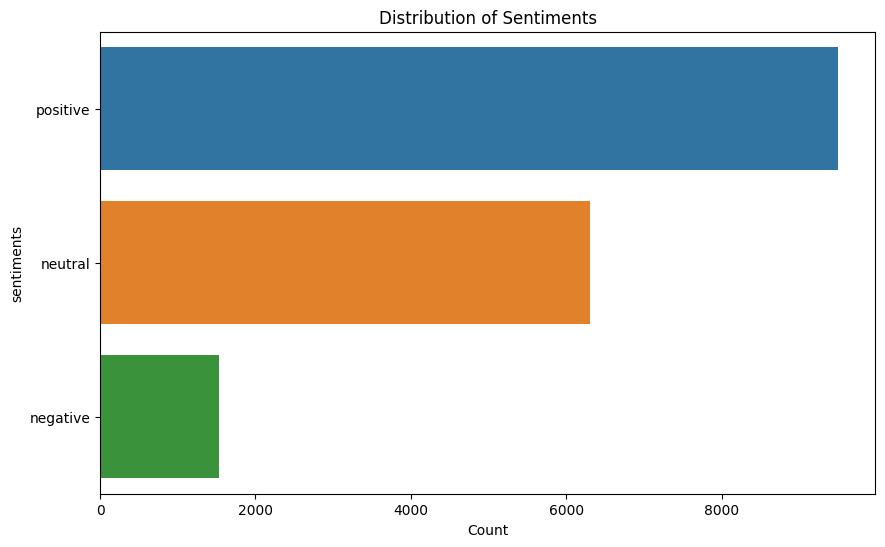


Statistik deskriptif untuk setiap label Sentiments:
           cleaned_review_length                                               \
                           count       mean        std  min   25%   50%   75%   
sentiments                                                                      
negative                  1534.0  43.981095  39.428504  1.0  19.0  32.0  57.0   
neutral                   6303.0  22.823259  25.738447  0.0   6.0  15.0  31.0   
positive                  9503.0  33.051457  39.729465  1.0  10.0  21.0  41.0   

                  review_score                                               
              max        count      mean       std  min  25%  50%  75%  max  
sentiments                                                                   
negative    363.0       1534.0  3.362451  1.753289  1.0  1.0  4.0  5.0  5.0  
neutral     360.0       6303.0  3.492464  1.715545  1.0  1.0  4.0  5.0  5.0  
positive    571.0       9503.0  3.799221  1.615702  1.0  2.0  5.0  5.0

In [38]:
# Menampilkan jumlah setiap kategori
label_count = df['sentiments'].value_counts()

# Plotting jumlah setiap kategori
plt.figure(figsize=(10, 6))
sns.countplot(y='sentiments', data=df, order=label_count.index)
plt.xlabel('Count')
plt.ylabel('sentiments')
plt.title('Distribution of Sentiments')
plt.show()

# Menampilkan statistik deskriptif
category_stats = df.groupby('sentiments').describe()
print("\nStatistik deskriptif untuk setiap label Sentiments:")
print(category_stats)

Pre-process

In [39]:
def preprocess_text(text):

    # remove punctuation
    text = ''.join([char for char in text if char.isalnum() or char.isspace()])

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    text = ' '.join([word for word in word_tokens if word.lower() not in stop_words])

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    return text

In [40]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17340 entries, 0 to 17339
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sentiments             17340 non-null  object 
 1   cleaned_review         17337 non-null  object 
 2   cleaned_review_length  17340 non-null  int64  
 3   review_score           17340 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 542.0+ KB


In [42]:
import nltk
nltk.download('punkt')
df['cleaned_review'] = df['cleaned_review'].astype(str)

# Apply preprocessing to each headline
df['cleaned_review'] = df['cleaned_review'].apply(preprocess_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [43]:
# Save the cleaned data to a new CSV file
df.to_csv('cleaned_reviews_after.csv', index=False)

Augmentasi Data

In [44]:
df = pd.read_csv("cleaned_reviews_after.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17340 entries, 0 to 17339
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sentiments             17340 non-null  object 
 1   cleaned_review         17313 non-null  object 
 2   cleaned_review_length  17340 non-null  int64  
 3   review_score           17340 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 542.0+ KB


In [45]:
df['cleaned_review'] = df['cleaned_review'].astype(str)

In [46]:
# Apply Easy Data Augmentation
aug = naw.SynonymAug()
augmented_data = []

for review in tqdm(df['cleaned_review']):
    augmented_data.append(aug.augment(review, n=3))

  0%|          | 0/17340 [00:00<?, ?it/s]

100%|██████████| 17340/17340 [01:51<00:00, 156.20it/s]


In [47]:
# List of List to list
augmented_data = [item for sublist in augmented_data for item in sublist]

In [48]:
# Create a DataFrame for augmented data
augmented_df = pd.DataFrame({'cleaned_review': augmented_data, 'sentiments': "positive"})

# Combine original data and augmented data
combined_data = pd.concat([df[['cleaned_review', 'sentiments']], augmented_df], ignore_index=True)

# Save the combined data to a CSV file
combined_data.to_csv('cleaned_review_afterV2.csv', index=False)

In [49]:
df = pd.read_csv("cleaned_review_afterV2.csv")

df['cleaned_review'] = df['cleaned_review'].astype(str)

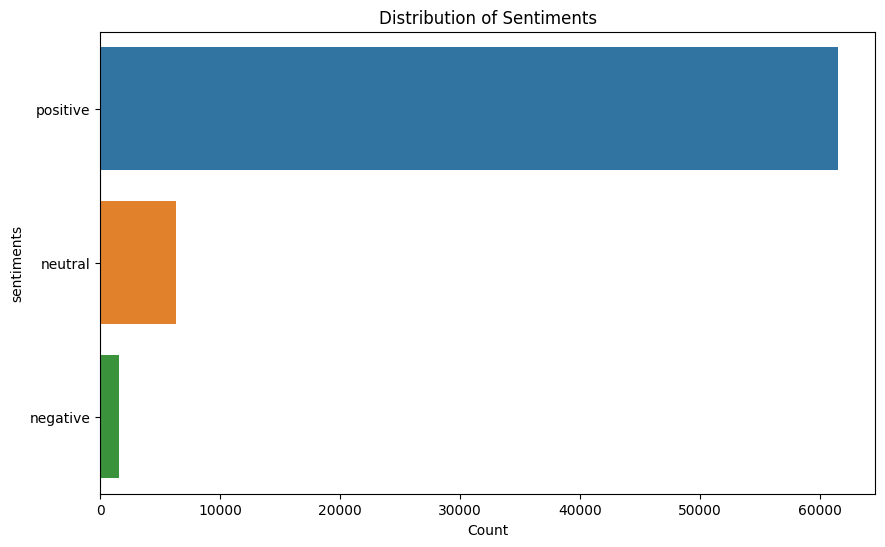


Statistik deskriptif untuk setiap label Sentiments:
           cleaned_review                      
                    count unique       top freq
sentiments                                     
negative             1534   1105  horrible    4
neutral              6303   4358      good   66
positive            61523  55413      love  105


In [50]:
# Menampilkan jumlah setiap kategori
label_count = df['sentiments'].value_counts()

# Plotting jumlah setiap kategori
plt.figure(figsize=(10, 6))
sns.countplot(y='sentiments', data=df, order=label_count.index)
plt.xlabel('Count')
plt.ylabel('sentiments')
plt.title('Distribution of Sentiments')
plt.show()

# Menampilkan statistik deskriptif
category_stats = df.groupby('sentiments').describe()
print("\nStatistik deskriptif untuk setiap label Sentiments:")
print(category_stats)

Tokenization with GloVe Support

In [51]:
#Tokenize the text
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned_review'])

#Convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(df['cleaned_review'])

#Pad sequences
max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

word_index = tokenizer.word_index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

#Select a single padded sequence
padded_sequence = padded_sequences[0]

#Print each token in the sequence and the corresponding word
for token in padded_sequence:
    if token != 0:
        print(f"Token: {token}, Word: {reverse_word_index[token]}")

Token: 178, Word: wish
Token: 14, Word: would
Token: 665, Word: gotten
Token: 10, Word: one
Token: 3056, Word: earlier
Token: 8, Word: love
Token: 56, Word: make
Token: 25, Word: working
Token: 42, Word: laptop
Token: 65, Word: much
Token: 807, Word: easier


In [52]:
#Load GloVe Embeddings
glove_embeddings = {}
with open('glove.6B.100d.txt', encoding='utf-8') as glove_file:
  for line in glove_file:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_embeddings[word] = coefs

In [53]:
#Define vocabulary size for the embedding layer
vocabulary_size = len(tokenizer.word_index)+1

#Prepare the Embedding layer weights using GloVe embeddings
embedding_dim = 100
embedding_weights = np.zeros((vocabulary_size, embedding_dim))
for word, i in tokenizer.word_index.items():
  embedding_vector = glove_embeddings.get(word)
  if embedding_vector is not None:
    embedding_weights[i] = embedding_vector

SMOTE

In [54]:
#Count the instances of each category in the original data
original_label = df['sentiments']
counter_original = Counter(original_label)
print("Original data:", counter_original)

Original data: Counter({'positive': 61523, 'neutral': 6303, 'negative': 1534})


In [55]:
#Encode the text labels to integers
le = LabelEncoder()
integer_categories = le.fit_transform(original_label)

In [56]:
#Apply SMOTE
smote = SMOTE(random_state = 42, k_neighbors=4)
padded_sequences_res, integer_categories_res = smote.fit_resample(padded_sequences, integer_categories)

#Reverse the integer encoding for the categories
categories_resampled = le.inverse_transform(integer_categories_res)

#Count the instance of each category in the resampled data
counter_resampled = Counter(categories_resampled)
print("\nData after SMOTE:", counter_resampled)

one_hot_categories = to_categorical(integer_categories_res)


Data after SMOTE: Counter({'positive': 61523, 'neutral': 61523, 'negative': 61523})


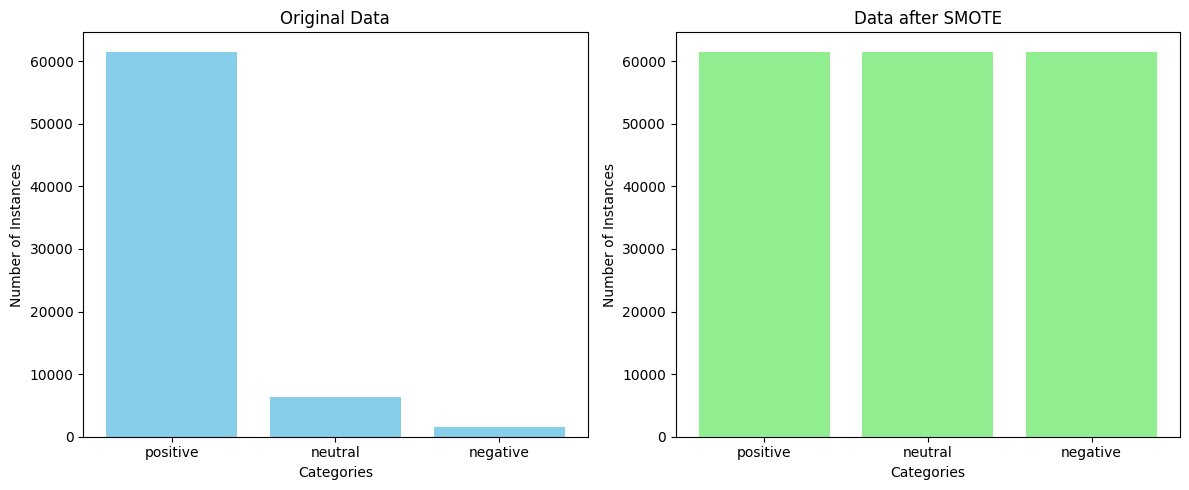

In [57]:
import matplotlib.pyplot as plt

# Data sebelum SMOTE
original_labels = list(counter_original.keys())
original_counts = list(counter_original.values())

# Data setelah SMOTE
resampled_labels = list(counter_resampled.keys())
resampled_counts = list(counter_resampled.values())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Diagram batang untuk data sebelum SMOTE
ax1.bar(original_labels, original_counts, color='skyblue')
ax1.set_title('Original Data')
ax1.set_xlabel('Categories')
ax1.set_ylabel('Number of Instances')

# Diagram batang untuk data setelah SMOTE
ax2.bar(resampled_labels, resampled_counts, color='lightgreen')
ax2.set_title('Data after SMOTE')
ax2.set_xlabel('Categories')
ax2.set_ylabel('Number of Instances')

plt.tight_layout()
plt.show()

Modeling

In [58]:
# Split datasets into train, validation, and test: 70% train, 20% validation, 10% test
x_train, x_temp, y_train, y_temp = train_test_split(padded_sequences_res, one_hot_categories, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.33, random_state=42)

In [59]:
# Check the sizes of the resulting splits
print("Train data shape:", x_train.shape, y_train.shape)
print("Validation data shape:", x_val.shape, y_val.shape)
print("Test data shape:", x_test.shape,y_test.shape)

Train data shape: (129198, 314) (129198, 3)
Validation data shape: (37098, 314) (37098, 3)
Test data shape: (18273, 314) (18273, 3)


In [60]:
print(len(le.classes_))

3


In [61]:
# Construct a simpler LSTM model
model_lstm_simple = Sequential()

# Embedding layer
model_lstm_simple.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, weights=[embedding_weights], input_length=max_sequence_length, trainable=False))

# First LSTM layer with BatchNormalization
model_lstm_simple.add(LSTM(64, return_sequences=True, dropout=0.1))
model_lstm_simple.add(BatchNormalization())

# Second LSTM layer with BatchNormalization
model_lstm_simple.add(LSTM(32, return_sequences=False, dropout=0.1))
model_lstm_simple.add(BatchNormalization())

# Output layer
model_lstm_simple.add(Dense(len(le.classes_), activation='softmax'))

In [62]:
adam = Adam(learning_rate=0.001)
model_lstm_simple.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# Define ReduceLROnPlateau and EarlyStopping callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [64]:
# Fit Model
history_lstm_simple = model_lstm_simple.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=64, epochs=3)

Epoch 1/3
2019/2019 [==============================] - 801s 397ms/step - loss: 0.6142 - accuracy: 0.7163 - val_loss: 0.6036 - val_accuracy: 0.7167
Epoch 2/3
2019/2019 [==============================] - 1238s 613ms/step - loss: 0.5906 - accuracy: 0.7268 - val_loss: 0.5714 - val_accuracy: 0.7331
Epoch 3/3
2019/2019 [==============================] - 697s 345ms/step - loss: 0.5680 - accuracy: 0.7354 - val_loss: 0.5574 - val_accuracy: 0.7393


1160/1160 [==============================] - 200s 172ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


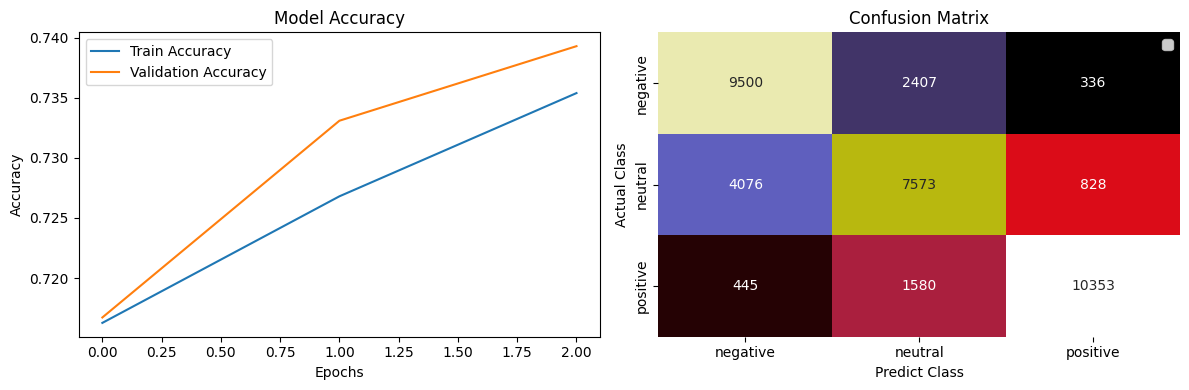

In [65]:
from sklearn.metrics import confusion_matrix

# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_lstm_simple.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm_simple.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Predict classes on validation data
y_val_pred = model_lstm_simple.predict(x_val)
y_val_pred_class = np.argmax(y_val_pred, axis=1)

# Convert one-hot encoded targets back to labels
y_val_classes = np.argmax(y_val, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_val_classes, y_val_pred_class)

# Plot confusion matrix as heatmap
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="gist_stern", cbar=False, xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.ylabel('Actual Class')
plt.xlabel("Predict Class")
plt.legend()

plt.tight_layout()
plt.show()


In [66]:
from sklearn.metrics import classification_report
import numpy as np

# Get Predictions
y_train_pred = model_lstm_simple.predict(x_train)
y_val_pred = model_lstm_simple.predict(x_val)

# Convert probabilities to class labels
y_train_pred_class = np.argmax(y_train_pred, axis=1)
y_val_pred_class = np.argmax(y_val_pred, axis=1)

# Convert one-hot encoded targets bact to labels
y_train_classes = np.argmax(y_train, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

# Compute and print classification report for training data
print("Training Data:")
print(classification_report(y_train_classes, y_train_pred_class, target_names=le.classes_))

# Compute and print classification report for validation data
print("Validation data:")
print(classification_report(y_val_classes, y_val_pred_class, target_names=le.classes_))

1160/1160 [==============================] - 82s 71ms/step
Training Data:
              precision    recall  f1-score   support

    negative       0.70      0.80      0.74     43184
     neutral       0.68      0.63      0.65     42960
    positive       0.92      0.87      0.89     43054

    accuracy                           0.76    129198
   macro avg       0.77      0.76      0.76    129198
weighted avg       0.77      0.76      0.76    129198

Validation data:
              precision    recall  f1-score   support

    negative       0.68      0.78      0.72     12243
     neutral       0.66      0.61      0.63     12477
    positive       0.90      0.84      0.87     12378

    accuracy                           0.74     37098
   macro avg       0.74      0.74      0.74     37098
weighted avg       0.74      0.74      0.74     37098

